#**BASIC IMPORTS**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from torch import optim
import cv2
from PIL import Image
from io import open
import os,string,random
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,LabelEncoder
import pickle
from sklearn.model_selection import train_test_split
from torchsummary import summary
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import cv2 as cv
from tabulate import tabulate

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**DATA PREPROCESSING**

##DATALOADER CLASS

Data Augmentation
1. Image Resizing
2. Image Flipping
3. Add noise
4. Blur img
5. Normalization

In [ ]:
class PlantImageDataloader(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                labels_list=[]
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                    labels_dict[plant_name] = labels_list
                else:
                    dataset_dict[plant_name].extend(images_list)
                    labels_dict[plant_name].extend(labels_list)

        except Exception as e:
            print(f"Error : {e}")

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('_')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []

        if end>=self.n[plant_name]:
            batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
            end = self.n[plant_name]
        return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch = label_batch

        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

##OTHER DATALODER CLASS

In [ ]:
class PlantImageDataloader3(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                labels_list=[]
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                    labels_dict[plant_name] = labels_list
                else:
                    dataset_dict[plant_name].extend(images_list)
                    labels_dict[plant_name].extend(labels_list)

        except Exception as e:
            print(f"Error : {e}")

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('_')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name,tr=0):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []

        if tr==0:
            if end>=self.n[plant_name]:
                batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
        else:
            if end>=self.n[plant_name]:
                batch = [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name,tr=1)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch = label_batch

        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform2 = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.6),     
                    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation((-30,30))]),0.75),
])                                       

In [ ]:
# path = f"drive/My Drive/Plant Disease Identification/PlantVillage"
# train_data = PlantImageDataloader(path,image_transform)

In [ ]:
# image_file = open("images_dict1.pkl","wb")
# label_file = open("labels_dict1.pkl","wb")
# pickle.dump(train_data.images_dict,image_file)
# pickle.dump(train_data.labels_dict,label_file)
# image_file.close()
# label_file.close()

##LOAD DATA

In [ ]:
#path_load = f"drive/Shared with me/Aditya Arnav-CropDisease/Code"
path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
image_dict_file= open(f"{path_load}/images_dict_1.pkl","rb")
label_dict_file= open(f"{path_load}/labels_dict1.pkl","rb")
image_dict_saved = pickle.load(image_dict_file)
label_dict_saved = pickle.load(label_dict_file)

In [ ]:
# path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
# obj_data = PlantImageDataloader(path,image_transform,images_dict=image_dict_saved,labels_dict=label_dict_saved)

In [ ]:
# obj_data.get_batch(2,"TOMATO")

#**DATA VISUALIZATION**

In [ ]:
def print_image(img_tensor,title="default",ax=plt,axis="off"):
    img_numpy = img_tensor.numpy()                  #convert the tensor back to nummpy array
    img_numpy = img_numpy*0.5 + 0.5                 #un-normalize the array
    img_numpy = np.transpose(img_numpy,(1,2,0))     #(channels,height,width)->(height,width,channels)
    ax.imshow(img_numpy)
    if ax==plt:
        ax.title(title,fontsize=20,va='top')
    else:
        ax.set_title(title,fontsize=5,va='top')
    ax.axis(axis)

def show_batch_img(images,labels,num_cols=4):
    n = len(images)                             #get the total number images
    num_rows = np.ceil(n/num_cols)              #get the number of rows based on the number of images in 1 row
    fig = plt.figure(figsize=(num_cols,num_rows),dpi=200)   #get a figure handler for the plot figure

    for i in range(n):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)        #add the figures 
        print_image(images[i],labels[i],ax=ax1)             #print the figures
    

In [ ]:
# show_batch_img(b_img,l_img)

In [ ]:
# a,b = train_data.get_batch(10,"TOMATO")
# show_batch_img(a,b)

#**TRAINING**

Test Train Split and Label Encodings

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(image_dict_saved["TOMATO"],
                                               label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=label_dict_saved["TOMATO"],
                                               random_state=0)

le = LabelEncoder()
Y_L_train = le.fit_transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.fit_transform(Y_val)

In [ ]:
# label_encoder_file = open("label_encoder","wb")
# pickle.dump(le,label_encoder_file)
# label_encoder_file.close()

In [ ]:
train_img_dict = {}
val_img_dict={}
train_label_dict={}
val_label_dict={}
train_img_dict["TOMATO"] = X_train
val_img_dict["TOMATO"] = X_val
train_label_dict["TOMATO"] = Y_L_train
val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,train_img_dict,train_label_dict)
val_data = PlantImageDataloader(path,image_transform,val_img_dict,val_label_dict)

##TRAINING FUNCTIONS

In [ ]:
def train_batch(net,criterion,data,lr=0.0001,batch_size=128,epochs=1000,plant_name="TOMATO",display=True,device='cpu'):
    min_loss = 1000
    loss_arr=[]
    opt = optim.Adam(net.parameters(),lr=lr)

    for i in range(epochs):
        net.train().to(device)
        opt.zero_grad()
        img_batch,label_batch = data.get_batch(batch_size,plant_name,1)
        img_batch,label_batch = img_batch.to(device),label_batch.to(device)    

        output = net(img_batch)
        loss = criterion(output,label_batch.long())

        loss.backward()
        opt.step()
        if loss<min_loss:
            best_model = net
            min_loss=loss
            print("Min loss model saved with LOSS= ",min_loss)

        loss_arr.append(loss)
        if display and (i%10==0):

            clear_output(wait=True)
            print('Iteration',i,'Loss',loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[0:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    
    return loss_arr,best_model

In [ ]:
def infer(net,inputs,le=None,original=False,device="cpu"):
    net.to(device)
    pred_outputs = net(inputs)

    pred_output_labels = torch.argmax(pred_outputs,1)
    # if original:
    #     pred_output_labels = le.inverse_transform(pred_output_labels.to("cpu").numpy())
    
    return [pred_output_labels[i].item() for i in range(len(pred_output_labels))]

In [ ]:
def calc_accuracy(net,test_data,batch_size=128,device='cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(test_data.n["TOMATO"]):          #tr_epochs
        images,labels = test_data.get_batch(batch_size,flag=1)
        images,labels = images.to(device), labels.to(device)
        outputs = infer(net,images,device=device)
        correct = 0
        for index,out in enumerate(outputs):
            if out == labels[index]:
                correct+=1

        accuracy+=correct/len(outputs)

    accuracy/=len(test_data)
    return accuracy

In [ ]:
def predict(net,data,batch_size=1,plant_name="TOMATO",device="cpu"):
    img,label = data.get_batch(batch_size,"TOMATO",1)
    img = img.to(device)
    max_val,pred_label = torch.max(net(img),1)
    pred_label = le.inverse_transform(pred_label.to("cpu").numpy())
    true_label = le.inverse_transform(np.array(label,dtype=np.int))
    d = {"TRUE LABEL":true_label,"PREDICTED LABEL":pred_label}
    df = pd.DataFrame(d)
    print(tabulate(df, headers='keys', tablefmt='psql'))
    #print("The true class is",)
    #print("The predicted class is",pred_label)

#**RESNET 50 MODEL**

In [ ]:
resnet_structure = models.resnet50()
print(resnet_structure)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##RESNET CASE-0: This model trains the fully connected layer of the original resnet model

In [ ]:
resnet_0 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_0.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_0.fc.in_features
resnet_0.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())

TRAINING

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(1.7891, device='cuda:0', grad_fn=<NllLossBackward>)


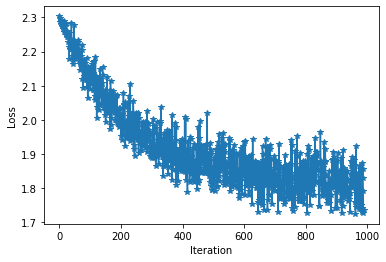

In [ ]:
resnet_0_loss_arr,best_resnet_0 = train_batch(resnet_0,criterion,train_data,lr=0.00005,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_0,val_data,128,device=device_gpu)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.7264844400499584

In [ ]:
torch.save(best_resnet_0,"resnet_0.1")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_0.1"
resnet_0 = torch.load(path)

Iteration 490 Loss tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward>)


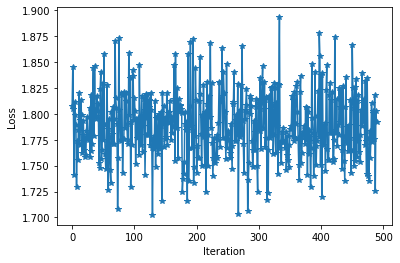

In [ ]:
resnet_0_loss_arr_1,best_resnet_0_1 = train_batch(resnet_0,criterion,train_data,lr=0.00001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_0_1,val_data,128,device=device_gpu)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.7267413873855121

In [ ]:
predict(best_resnet_0,val_data,10,device=device_gpu)

+----+--------------+-------------------+
|    | TRUE LABEL   | PREDICTED LABEL   |
|----+--------------+-------------------|
|  0 | LEAF SPOT    | LEAF SPOT         |
|  1 | EARLY BLIGHT | BACTERIAL SPOT    |
|  2 | LEAF MOLD    | LEAF SPOT         |
|  3 | EARLY BLIGHT | LATE BLIGHT       |
|  4 | SPIDER MITE  | SPIDER MITE       |
|  5 | SPIDER MITE  | SPIDER MITE       |
|  6 | LEAF MOLD    | SPIDER MITE       |
|  7 | CURL VIRUS   | CURL VIRUS        |
|  8 | LEAF SPOT    | LEAF SPOT         |
|  9 | LEAF SPOT    | LEAF SPOT         |
+----+--------------+-------------------+


##RESNET CASE-1: This model trains the last conv2d and the fully connected layer of the original resnet model

In [ ]:
resnet_1 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_1.parameters():
    param.requires_grad_(False)

Referring to the above resnet50 structure we will unfreeze some parts of the third bottleneck of the layer4. We will also change the fully connected layer in the end to match the number of labels availabe for our disease.
 

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_1.layer4[2].parameters():
    if count>=6:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_1.fc.in_features
resnet_1.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())

In [ ]:
summary(resnet_1, (3,224,224),device="cpu")         #trainable parameters are 10,73,162

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


TRAINING

Iteration 990 Loss tensor(1.6373, device='cuda:0', grad_fn=<NllLossBackward>)


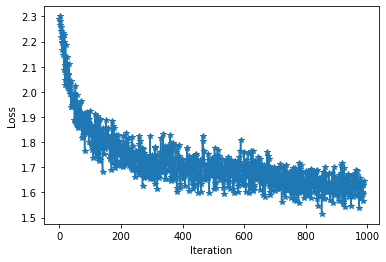

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_1_loss_arr,best_resnet_1 = train_batch(resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

Iteration 990 Loss tensor(1.4818, device='cuda:0', grad_fn=<NllLossBackward>)


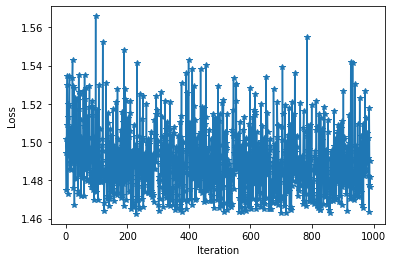

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_1_loss_arr,best_resnet_1 = train_batch(resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(resnet_1,val_data,128,device_gpu)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9254364852206495

In [ ]:
torch.save(best_resnet_1,"resnet_1.1")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_1.1"
saved_resnet_1 = torch.load(path)

In [ ]:
calc_accuracy(saved_resnet_1,val_data,128,device_gpu)

Iteration 990 Loss tensor(1.4653, device='cuda:0', grad_fn=<NllLossBackward>)


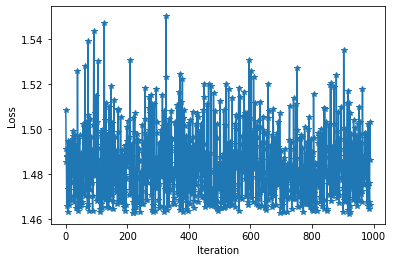

In [ ]:
resnet_1_loss_arr,best_resnet_1 = train_batch(saved_resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
predict(saved_resnet_1,train_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | SPIDER MITE    | SPIDER MITE       |
|  1 | LATE BLIGHT    | LATE BLIGHT       |
|  2 | EARLY BLIGHT   | EARLY BLIGHT      |
|  3 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  4 | CURL VIRUS     | CURL VIRUS        |
|  5 | HEALTHY        | HEALTHY           |
|  6 | LEAF SPOT      | LEAF SPOT         |
|  7 | TARGET SPOT    | TARGET SPOT       |
|  8 | LEAF SPOT      | LEAF SPOT         |
|  9 | TARGET SPOT    | TARGET SPOT       |
+----+----------------+-------------------+


##RESNET CASE-2: This model trains the last two convolutional layers along with the fully connected layer of the original resnet model

In [ ]:
resnet_2 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_2.parameters():
    param.requires_grad_(False)

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_2.layer4[2].parameters():
    if count>=3:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_2.fc.in_features
resnet_2.fc = nn.Linear(final_in_features,new_out_features)

In [ ]:
summary(resnet_2, (3, 224, 224),device="cpu")       #Trainable parameters are 34,33,482

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

TRAINING

Iteration 990 Loss tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)


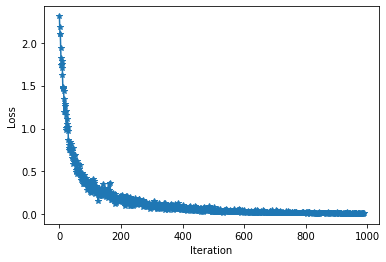

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_2_loss_arr = train_batch(resnet_2,criterion,train_data,lr=0.0001,batch_size=128,epochs=1000,device=device_gpu)

In [ ]:
calc_accuracy(resnet_2,val_data,128,device_gpu)

0.9750078059950041

In [ ]:
torch.save(resnet_2,"resnet_2.1")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_2.1"
saved_resnet_2 = torch.load(path)

In [ ]:
resnet_2_loss_arr,best_resnet_2 = train_batch(saved_resnet_2,criterion,train_data,lr=0.0001,batch_size=128,epochs=1000,display=True,device=device_gpu)

In [ ]:
predict(saved_resnet_2,val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | TARGET SPOT    | TARGET SPOT       |
|  1 | EARLY BLIGHT   | EARLY BLIGHT      |
|  2 | LEAF SPOT      | LEAF SPOT         |
|  3 | LEAF SPOT      | LEAF SPOT         |
|  4 | SPIDER MITE    | SPIDER MITE       |
|  5 | TARGET SPOT    | TARGET SPOT       |
|  6 | LEAF SPOT      | LEAF SPOT         |
|  7 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  8 | HEALTHY        | HEALTHY           |
|  9 | LATE BLIGHT    | LATE BLIGHT       |
+----+----------------+-------------------+


#**Inception+Resnet**


##MODEL DEFINITION

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
c_resnet = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in c_resnet.parameters():
    param.requires_grad_(False)

In [ ]:
print(c_resnet.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [ ]:
c_resnet.layer4[0] = inception_block(1024,2048)
c_resnet.layer4[1] = inception_block(2048,2048)
c_resnet.layer4[2] = inception_block(2048,2048)
c_resnet.fc = nn.Linear(2048,10)

In [ ]:
print(c_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##TRAINING INCEPTION-RESNET

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward>)


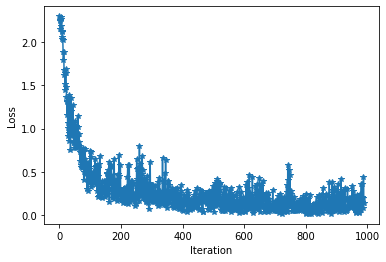




Min loss model saved with LOSS=  tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
c_resnet_loss_arr,inc_resnet_best_model_1 = train_batch(c_resnet,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

Iteration 390 Loss tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)


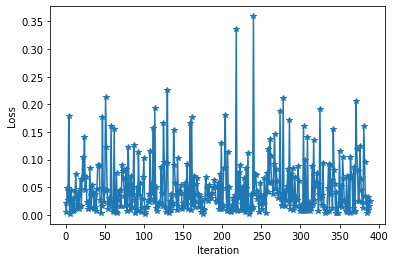

In [ ]:
c_resnet_loss_arr,inc_resnet_best_model_1 = train_batch(inc_resnet_best_model,criterion,train_data,lr=0.00001,batch_size=32,epochs=400,display=True,device=device_gpu)

In [ ]:
calc_accuracy(c_resnet,val_data,128,device_gpu)

0.969211854704413

In [ ]:
calc_accuracy(inc_resnet_best_model,val_data,128,device_gpu)

0.9754794181931724

In [ ]:
torch.save(inc_resnet_best_model,"inception_resnet_3")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Inception Resnet Models/inception_resnet_3"
inc_resnet_best_model = torch.load(path)

Iteration 490 Loss tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward>)


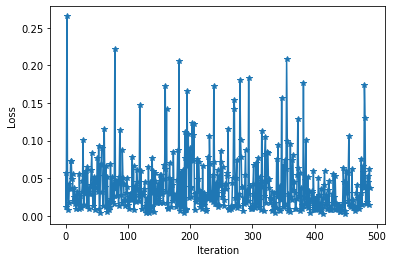

In [ ]:
inc_resnet_loss_arr,inc_resnet_best_model_1 = train_batch(inc_resnet_best_model,criterion,train_data,lr=0.0000001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(inc_resnet_best_model_1,val_data,128,device_gpu)

0.9816851842214821

In [ ]:
torch.save(inc_resnet_best_model_1,"inc_resnet_4")

In [ ]:
predict(inc_resnet_best_model,val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | TARGET SPOT    | TARGET SPOT       |
|  1 | EARLY BLIGHT   | EARLY BLIGHT      |
|  2 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  3 | CURL VIRUS     | CURL VIRUS        |
|  4 | TARGET SPOT    | TARGET SPOT       |
|  5 | LEAF SPOT      | LEAF SPOT         |
|  6 | CURL VIRUS     | CURL VIRUS        |
|  7 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  8 | SPIDER MITE    | SPIDER MITE       |
|  9 | SPIDER MITE    | SPIDER MITE       |
+----+----------------+-------------------+


In [ ]:
# path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Inception Resnet Models/inception_resnet_4"
# i = torch.load(path)

In [ ]:
# calc_accuracy(i,val_data,128,device_gpu)

0.9816624167360533

#**PLANTDOC SECTION**

##DATA READING AND LOADING

In [ ]:
class PlantImageDataloader2(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        plant_name="TOMATO"         #change
        for image_folder in os.listdir(filename):
            disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
            folders_path = f"{filename}/{image_folder}"             
            images_list = []
            labels_list=[]
            print("[INFO] Reading the folder",image_folder)         
            i=0
            for image_name in os.listdir(f"{filename}/{image_folder}"):
                try:
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                      
                    current_image = img_transform(current_image)           
                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%10==0:
                        print("Read ",i," images in ",image_folder,"folder")
                        #print(current_image) 
                except Exception as e:
                    print("Skipping"+image_name)
                    print(f"Error : {e}")                           
            if plant_name not in dataset_dict.keys():
                dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                labels_dict[plant_name] = labels_list
            else:
                dataset_dict[plant_name].extend(images_list)
                labels_dict[plant_name].extend(labels_list)
        

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('-')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        pos = name.rfind("leaf") + 4
        disname = name[pos:].strip().upper()
        if disname=="MOLD":
            disname="LEAF MOLD"
        if disname=="SPOT":
            disname = "LEAF SPOT"
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name,tr=0):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []
        if tr==0:
            if end>=self.n[plant_name]:
                batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
        else:
            if end>=self.n[plant_name]:
                batch = [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name,tr=1)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch=label_batch
        #print()
        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
image_transform2 = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.6),     
                    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation((-30,30))]),0.5),
])                                       

In [ ]:
plantdoc_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
plantdoc_image_dict_file= open(f"{path_load}/plantdoc_trainimages_dict.pkl","rb")
plantdoc_label_dict_file= open(f"{path_load}/plantdoc_trainlabels_dict.pkl","rb")
plantdoc_image_dict_saved = pickle.load(plantdoc_image_dict_file)
plantdoc_label_dict_saved = pickle.load(plantdoc_label_dict_file)

##TRAINING

In [ ]:
X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
plantdoc_train_img_dict = {}
plantdoc_val_img_dict={}
plantdoc_train_label_dict={}
plantdoc_val_label_dict={}
plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

##RESNET-0 FOR PLANTDOC

In [ ]:
resnet0_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_0.1"
pd_resnet0 = torch.load(resnet0_path)

In [ ]:
calc_accuracy(pd_resnet0,plantdoc_val_data,64,device_gpu)

0.23973651960784315

Iteration 490 Loss tensor(2.1443, device='cuda:0', grad_fn=<NllLossBackward>)


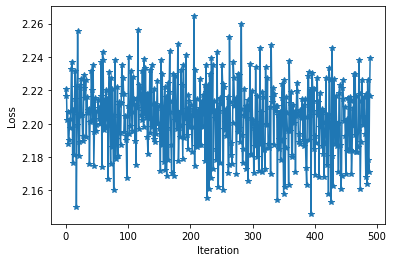

In [ ]:
l_r0,bm_r0 = train_batch(pd_resnet0,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_r0,plantdoc_val_data,64,device_gpu)

0.2610294117647059

##RESNET-1 FOR PLANTDOC

In [ ]:
resnet1_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_1.1"
pd_resnet1 = torch.load(resnet1_path)

In [ ]:
calc_accuracy(pd_resnet1,plantdoc_val_data,64,device_gpu)

0.29518995098039214

Iteration 490 Loss tensor(2.2205, device='cuda:0', grad_fn=<NllLossBackward>)


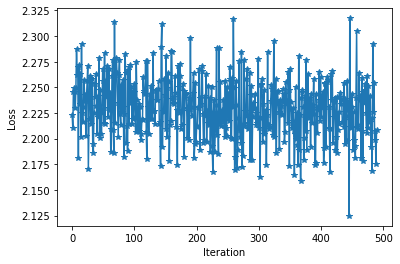

In [ ]:
l_r1,bm_r1 = train_batch(pd_resnet1,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_r1,plantdoc_val_data,64,device_gpu)

0.21001838235294118

##RESNET-2 FOR PLANTDOC

In [ ]:
resnet2_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_2.1"
pd_resnet2 = torch.load(resnet2_path)

In [ ]:
calc_accuracy(pd_resnet2,plantdoc_val_data,64,device_gpu)

0.2725183823529412

Iteration 490 Loss tensor(3.1146, device='cuda:0', grad_fn=<NllLossBackward>)


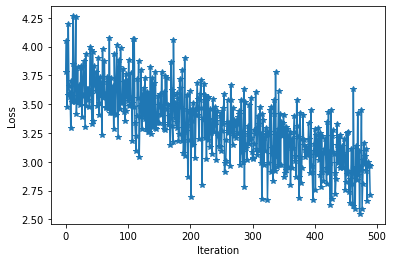




Min loss model saved with LOSS=  tensor(2.3441, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
l_r2,bm_r2 = train_batch(pd_resnet2,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_r2,plantdoc_val_data,64,device_gpu)

0.2545955882352941

##INC-RESNET FOR PLANTDOC

In [ ]:
incresnet_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Inception Resnet Models/inception_resnet_4"
pd_incresnet = torch.load(incresnet_path)

In [ ]:
calc_accuracy(pd_incresnet,plantdoc_val_data,64,device_gpu)

0.27205882352941174

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Inception Resnet Models/inception_resnet_4"
plantdoc_inc_resnet = torch.load(path)

Iteration 490 Loss tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)


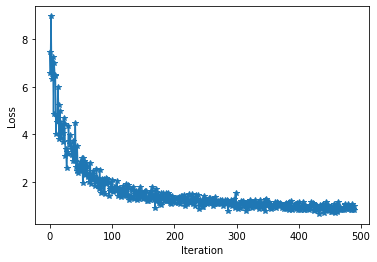

In [ ]:
pd_l,pd_bm = train_batch(plantdoc_inc_resnet,criterion,plantdoc_train_data,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

Iteration 490 Loss tensor(0.8497, device='cuda:0', grad_fn=<NllLossBackward>)


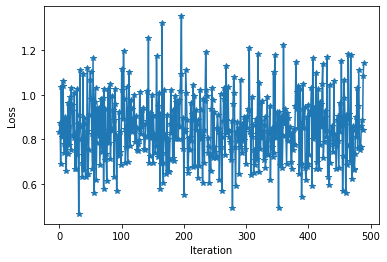

In [ ]:
pd_l2,pd_bm2 = train_batch(pd_bm,criterion,plantdoc_train_data,lr=0.0000001,batch_size=32,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(pd_bm2,plantdoc_val_data,64,device_gpu)

0.5228247549019608

In [ ]:
predict(pd_bm,plantdoc_val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | LEAF MOLD      | LATE BLIGHT       |
|  1 | BACTERIAL SPOT | LEAF SPOT         |
|  2 | BACTERIAL SPOT | LATE BLIGHT       |
|  3 | LEAF MOLD      | LEAF MOLD         |
|  4 | BACTERIAL SPOT | LEAF MOLD         |
|  5 | LEAF SPOT      | LEAF SPOT         |
|  6 | LEAF MOLD      | LEAF MOLD         |
|  7 | LEAF SPOT      | BACTERIAL SPOT    |
|  8 | CURL VIRUS     | LEAF MOLD         |
|  9 | LEAF SPOT      | LEAF SPOT         |
+----+----------------+-------------------+


##TRAINING ATTEMPTS

Iteration 490 Loss tensor(2.0286, device='cuda:0', grad_fn=<NllLossBackward>)


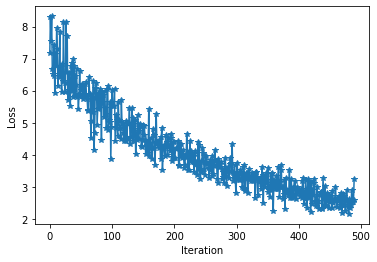

In [ ]:
# l_incr,bm_incr = train_batch(pd_incresnet,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
# calc_accuracy(bm_incr,plantdoc_val_data,64,device_gpu)

0.3795955882352941

Iteration 490 Loss tensor(1.5957, device='cuda:0', grad_fn=<NllLossBackward>)


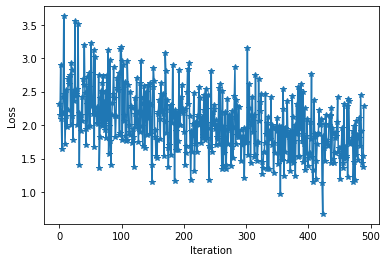

In [ ]:
# l_incr2,bm_incr2 = train_batch(bm_incr,criterion,plantdoc_train_data,lr=0.000001,batch_size=32,epochs=500,display=True,device=device_gpu)

In [ ]:
# calc_accuracy(bm_incr2,plantdoc_val_data,64,device_gpu)

0.4178921568627451

Iteration 490 Loss tensor(1.7971, device='cuda:0', grad_fn=<NllLossBackward>)


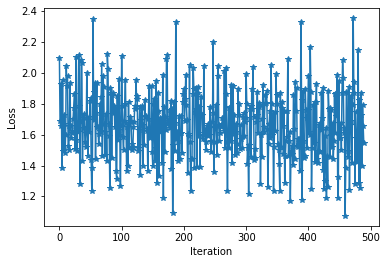

In [ ]:
# l_incr3,bm_incr3 = train_batch(bm_incr2,criterion,plantdoc_train_data,lr=0.0000001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
#calc_accuracy(bm_incr3,plantdoc_val_data,64,device_gpu)

0.42401960784313725

##SUBSECTION2

In [ ]:
pd_c_resnet = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in pd_c_resnet.parameters():
    param.requires_grad_(False)

In [ ]:
pd_c_resnet.layer4[0] = inception_block(1024,2048)
pd_c_resnet.layer4[1] = inception_block(2048,2048)
pd_c_resnet.layer4[2] = inception_block(2048,2048)
pd_c_resnet.fc = nn.Linear(2048,10)

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data_1 = PlantImageDataloader3(path,image_transform,train_img_dict,train_label_dict)
val_data_1 = PlantImageDataloader3(path,image_transform,val_img_dict,val_label_dict)

Iteration 490 Loss tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)


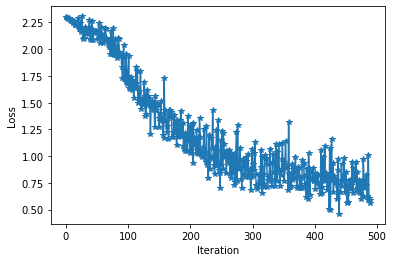

In [ ]:
l_1,bm_1 = train_batch(pd_c_resnet,criterion,train_data_1,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_1,val_data_1,64,device_gpu)

In [ ]:
torch.save(bm_1,"inc_resnet_aug_1")

Iteration 490 Loss tensor(0.7693, device='cuda:0', grad_fn=<NllLossBackward>)


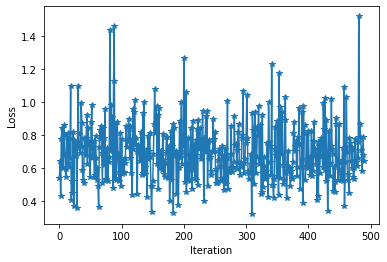

In [ ]:
l_2,bm_2 = train_batch(bm_1,criterion,train_data_1,lr=0.000001,batch_size=32,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_2,val_data_1,32,device_gpu)            #this is plantvillage

0.7790643213988343

In [ ]:
torch.save(bm_2,"inc_resnet_aug_2")

In [ ]:
pd_l_1,pd_bm_1 = train_batch(bm_1,criterion,plantdoc_train_data,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

#**NEW MODEL**

In [ ]:
class custom_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

#**MASK**


##EXTRAS


In [ ]:
# #_, mask = cv.threshold(im_gray, thresh=90, maxval=255, type=cv.THRESH_MASK)
# im_thresh =[]
# thresh = cv2.adaptiveThreshold(x,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,99,2)
# #thresh1 = cv2.adaptiveThreshold(im_gray,im_thresh,255.0,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_MASK,199,0)
# #im_thresh_gray = cv.bitwise_and(im_gray, mask)
# thresh2 = cv2.adaptiveThreshold(thresh,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,3,2)
# cv2_imshow(thresh)
# cv2_imshow(thresh2)

In [ ]:
# ret2,th2 = cv.threshold(im_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# blur = cv2.GaussianBlur(im_gray,(49,49),0)
# ret3,th3 = cv.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# cv2_imshow(th2)
# cv2_imshow(th3)

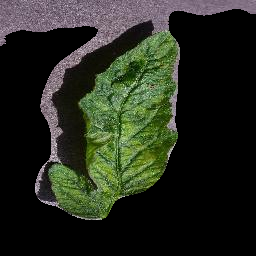

In [ ]:
cv2_imshow(cv2.bitwise_and(im_color,im_color,mask=th3))

In [ ]:
#a = cv2.imread("random_bkgrnd1.jpg",cv2.IMREAD_COLOR)
a = Image.open("random_bkgrnd1.jpg")
a = transforms.Resize(224)(a)
a = cv2.cvtColor(np.array(a),cv2.COLOR_BGR2RGB)
cv2_imshow(a)

In [ ]:
#def apply_random_back(,background):

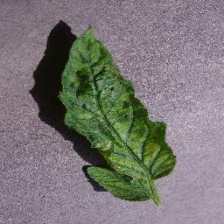

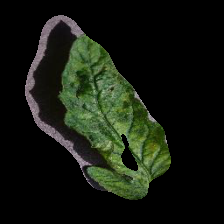

In [ ]:
#img = cv2.imread("IMG2.JPG", cv.IMREAD_COLOR)
img = Image.open("IMG.JPG")
img = transforms.Resize(224)(img)
img  = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
x = apply_mask(img)

In [ ]:
a = image_dict_saved["TOMATO"][1]
b = label_dict_saved["TOMATO"][1]
c = plantdoc_image_dict_saved["TOMATO"][1]
d = plantdoc_label_dict_saved["TOMATO"][1]

In [ ]:
a.size()

torch.Size([3, 224, 224])

In [ ]:
a = transforms.ToPILImage()(a)
c = transforms.ToPILImage()(c)

In [ ]:
a.size

(224, 224)

In [ ]:
apply_mask(a,c)

In [ ]:
pd_img = Image.open("pd_img.jpg")
pv_img = Image.open("pv_img.JPG")

In [ ]:
np.array(pv_img).shape

(256, 256, 3)

In [ ]:
pd_img = transforms.ToTensor()(pd_img)
pv_img = transforms.ToTensor()(pv_img)

In [ ]:
a = transforms.Resize((224,224))(pd_img)
b = transforms.Resize((224,224))(pv_img)

In [ ]:
a.size()

torch.Size([3, 224, 224])

In [ ]:
apply(pv_img,pd_img)

In [ ]:
z = x.copy()

In [ ]:
z[x==0] = 255
z[x>0] = 0

In [ ]:
k = x.copy()
k[x==0] = 255

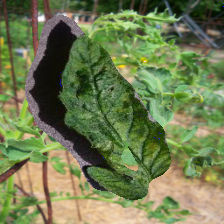

In [ ]:
cv2_imshow(cv2.bitwise_and(z,pdoc) + k)

In [ ]:
pdoc = Image.open("IMG2.jpg")
pdoc = transforms.Resize((224,224))(pdoc)
pdoc  = cv2.cvtColor(np.array(pdoc),cv2.COLOR_BGR2RGB)

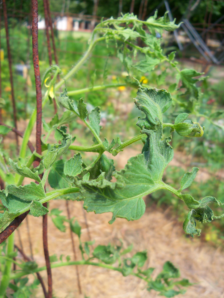

In [ ]:
cv2_imshow(pdoc)

In [ ]:
x[x==0] = 255

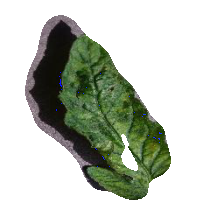

In [ ]:
cv2.bitwise

In [ ]:
u = Image.open("pv_img.JPG")

In [ ]:
get_mask(np.array(u))

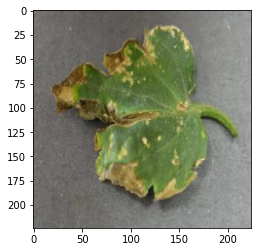

In [ ]:
k = (image_dict_saved["TOMATO"][2].numpy()*0.5)+0.5
plt.imshow(np.transpose(k,(2,1,0)))
#plt.imshow(k)

In [ ]:
u = torch.Tensor(((image_dict_saved["TOMATO"][2].numpy()*0.5)+0.5))
v = torch.Tensor((plantdoc_image_dict_saved["TOMATO"][2].numpy()*0.5)+0.5)
p = transforms.ToPILImage()(u)
q = transforms.ToPILImage()(v)
apply_mask(p,q)

In [ ]:
cv2_imshow(transforms.ToPILImage()(new_dataset_imgs["TOMATO"][5]))

In [ ]:
def unnormalize(img_tensor):
    x = img_tensor.numpy()
    x = (x*0.5)+0.5
    return torch.Tensor(x)

In [ ]:
a = torch.Tensor((x_i.numpy()*0.5+0.5))

In [ ]:
x = transforms.ToPILImage()(a)

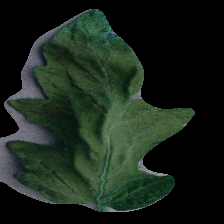

In [ ]:
cv2_imshow(get_mask(np.array(x)))

In [ ]:
get_mask(x)

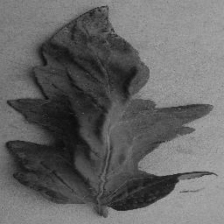

In [ ]:
im_gray = cv2.cvtColor(x,cv2.COLOR_BGR2GRAY)
cv2_imshow(im_gray*255)

In [ ]:
x_i = image_dict_saved["TOMATO"][100]
x_l = label_dict_saved["TOMATO"][100]
y_i = plantdoc_image_dict_saved["TOMATO"][20]
y_l = plantdoc_label_dict_saved["TOMATO"][20]

In [ ]:
(x_i.numpy()*0.5)+0.5

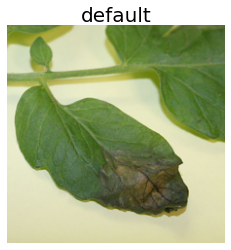

In [ ]:
print_image(y_i)

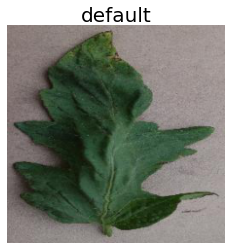

In [ ]:
#a = x_i.unsqueese(0)
print_image(x_i)

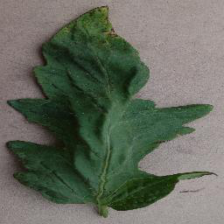

In [ ]:
cv2_imshow(cv2.cvtColor(np.transpose((x_i.numpy()*0.5+0.5)*255,(1,2,0)),cv2.COLOR_BGR2RGB))

In [ ]:
transforms.ToPILImage()((x_i.numpy()*0.5+0.5)*255)

In [ ]:
cv2_imshow(np.transpose((x_i.numpy()*0.5)+0.5,(1,2,0)))

In [ ]:
plantdoc_image_dict_saved["TOMATO"][1].size()

torch.Size([3, 224, 224])

##MAIN

In [ ]:
path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
image_dict_file= open(f"{path_load}/images_dict1.pkl","rb")
label_dict_file= open(f"{path_load}/labels_dict1.pkl","rb")
image_dict_saved = pickle.load(image_dict_file)
label_dict_saved = pickle.load(label_dict_file)

In [ ]:
plantdoc_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
plantdoc_image_dict_file= open(f"{path_load}/plantdoc_trainimages_dict.pkl","rb")
plantdoc_label_dict_file= open(f"{path_load}/plantdoc_trainlabels_dict.pkl","rb")
plantdoc_image_dict_saved = pickle.load(plantdoc_image_dict_file)
plantdoc_label_dict_saved = pickle.load(plantdoc_label_dict_file)

In [ ]:
def unnormalize(img_tensor):
    x = img_tensor.numpy()
    x = (x*0.5)+0.5
    return torch.Tensor(x)

In [ ]:
def apply_mask(pv_img, pd_img):
    pv = np.array(pv_img)
    pd = np.array(pd_img)
    temp1 = get_mask(pv)
    temp2 = temp1.copy()
    temp3 = temp1.copy()
    temp2[temp1==0] = 255
    temp2[(temp1>0)] = 0
    temp3[pv==0] = 255
    final = cv2.bitwise_and(temp2,pd)+temp3
    return final

In [ ]:
def get_mask(color_img):
    """pv is the color image of plant village in numpy array format"""
    im_gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(im_gray,(55,55),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    final_img = cv2.bitwise_and(color_img,color_img,mask=th)
    return final_img

In [ ]:
new_dataset_imgs = {}
new_dataset_labels = {}
new_dataset_imgs["TOMATO"] = []
new_dataset_labels["TOMATO"] = []

for i,label in enumerate(label_dict_saved["TOMATO"]):
    try:
        temp = [unnormalize(plantdoc_image_dict_saved["TOMATO"][j]) for j in range(len(plantdoc_label_dict_saved["TOMATO"])) if plantdoc_label_dict_saved["TOMATO"][j]==label]
        r = random.randint(0,len(temp)-1)
        pd_img = transforms.ToPILImage()(temp[r])
        pv_img = transforms.ToPILImage()(unnormalize(image_dict_saved["TOMATO"][i]))
        temp2 = apply_mask(pv_img,pd_img)
        temp2 = np.transpose(temp2,(2,0,1))
        temp2 = temp2/255
        final_tensor = torch.Tensor(temp2)
        final_tensor = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))(final_tensor)
        new_dataset_imgs["TOMATO"].append(final_tensor)
        new_dataset_labels["TOMATO"].append(label)
        if i%100==0:
            print("Read",i,"images")
    except Exception as e:
        print(f"Error : {e}")

Read 0 images
Read 100 images
Read 200 images
Read 300 images
Read 400 images
Read 500 images
Read 600 images
Read 700 images
Read 800 images
Read 900 images
Read 1000 images
Read 1100 images
Read 1200 images
Read 1300 images
Read 1400 images
Read 1500 images
Read 1600 images
Read 1700 images
Read 1800 images
Read 1900 images
Read 2000 images
Read 2100 images
Read 2200 images
Read 2300 images
Read 2400 images
Read 2500 images
Read 2600 images
Read 2700 images
Read 2800 images
Read 2900 images
Read 3000 images
Read 3100 images
Read 3200 images
Read 3300 images
Read 3400 images
Read 3500 images
Read 3600 images
Read 3700 images
Read 3800 images
Read 3900 images
Read 4000 images
Read 4100 images
Read 4200 images
Read 4300 images
Read 4400 images
Read 4500 images
Read 4600 images
Read 4700 images
Read 4800 images
Read 4900 images
Read 5000 images
Read 5100 images
Read 5200 images
Read 5300 images
Read 5400 images
Read 5500 images
Read 5600 images
Read 5700 images
Read 5800 images
Read 5900

In [ ]:
path = f""

In [ ]:
data = PlantImageDataloader(path,image_transform,images_dict=new_dataset_imgs,labels_dict=new_dataset_labels)

In [ ]:
a,b = data.get_batch(20,"TOMATO")

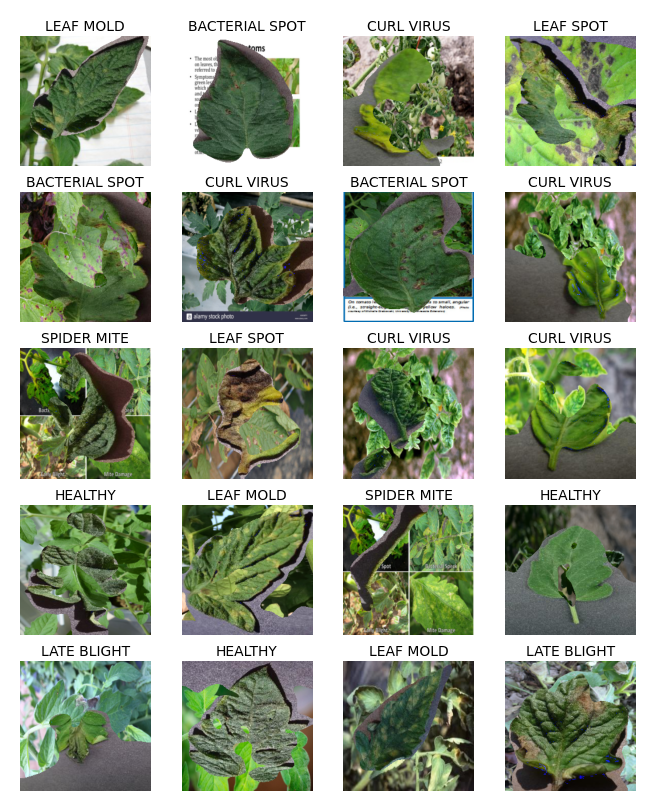

In [ ]:
show_batch_img(a,b)

In [ ]:
image_file = open("newdataset_images_dict.pkl","wb")
label_file = open("new_dataset_labels_dict.pkl","wb")
pickle.dump(new_dataset_imgs,image_file)
pickle.dump(new_dataset_labels,label_file)
image_file.close()
label_file.close()

#**TRAINING NEWDATASET**

##DATALOADER PLANTDOC CLASS FOR ACCURACY CALCULATION

In [ ]:
class PlantImageDataloader2(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        plant_name="TOMATO"         #change
        for image_folder in os.listdir(filename):
            disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
            folders_path = f"{filename}/{image_folder}"             
            images_list = []
            labels_list=[]
            print("[INFO] Reading the folder",image_folder)         
            i=0
            for image_name in os.listdir(f"{filename}/{image_folder}"):
                try:
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                      
                    current_image = img_transform(current_image)           
                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%10==0:
                        print("Read ",i," images in ",image_folder,"folder")
                        #print(current_image) 
                except Exception as e:
                    print("Skipping"+image_name)
                    print(f"Error : {e}")                           
            if plant_name not in dataset_dict.keys():
                dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                labels_dict[plant_name] = labels_list
            else:
                dataset_dict[plant_name].extend(images_list)
                labels_dict[plant_name].extend(labels_list)
        

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('-')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        pos = name.rfind("leaf") + 4
        disname = name[pos:].strip().upper()
        if disname=="MOLD":
            disname="LEAF MOLD"
        if disname=="SPOT":
            disname = "LEAF SPOT"
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name,tr=0):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []
        if tr==0:
            if end>=self.n[plant_name]:
                batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
        else:
            if end>=self.n[plant_name]:
                batch = [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name,tr=1)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch=label_batch
        #print()
        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
image_transform2 = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.6),     
                    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation((-30,30))]),0.5),
])                                       

In [ ]:
plantdoc_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
plantdoc_image_dict_file= open(f"{path_load}/plantdoc_trainimages_dict.pkl","rb")
plantdoc_label_dict_file= open(f"{path_load}/plantdoc_trainlabels_dict.pkl","rb")
plantdoc_image_dict_saved = pickle.load(plantdoc_image_dict_file)
plantdoc_label_dict_saved = pickle.load(plantdoc_label_dict_file)

##PLANTDOC BASIC VALIDATION DATA

METHOD1

In [ ]:
X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
plantdoc_train_img_dict = {}
plantdoc_val_img_dict={}
plantdoc_train_label_dict={}
plantdoc_val_label_dict={}
plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

METHOD2

In [ ]:
X_train_plantdoc2,X_val_plantdoc2,Y_train_plantdoc2,Y_val_plantdoc2 = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.95,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc2 = le.transform(Y_train_plantdoc2)
Y_L_val_plantdoc2 = le.transform(Y_val_plantdoc2)

In [ ]:
plantdoc_train_img_dict2 = {}
plantdoc_val_img_dict2={}
plantdoc_train_label_dict2={}
plantdoc_val_label_dict2={}
plantdoc_train_img_dict2["TOMATO"] = X_train_plantdoc2
plantdoc_val_img_dict2["TOMATO"] = X_val_plantdoc2
plantdoc_train_label_dict2["TOMATO"] = Y_L_train_plantdoc2
plantdoc_val_label_dict2["TOMATO"] = Y_L_val_plantdoc2

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data2 = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict2,plantdoc_train_label_dict2)
plantdoc_val_data2 = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict2,plantdoc_val_label_dict2)

##Test Train Split and Label Encodings

In [ ]:
path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
image_dict_file= open(f"{path_load}/newdataset_images_dict.pkl","rb")
label_dict_file= open(f"{path_load}/newdataset_labels_dict.pkl","rb")
new_dataset_imgs = pickle.load(image_dict_file)
new_dataset_labels = pickle.load(label_dict_file)

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(new_dataset_imgs["TOMATO"],
                                               new_dataset_labels["TOMATO"],
                                               test_size=0.15,
                                               stratify=new_dataset_labels["TOMATO"],
                                               random_state=0)

le = LabelEncoder()
Y_L_train = le.fit_transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.fit_transform(Y_val)

In [ ]:
# label_encoder_file = open("label_encoder","wb")
# pickle.dump(le,label_encoder_file)
# label_encoder_file.close()

In [ ]:
new_dataset_train_img_dict = {}
new_dataset_val_img_dict={}
new_dataset_train_label_dict={}
new_dataset_val_label_dict={}
new_dataset_train_img_dict["TOMATO"] = X_train
new_dataset_val_img_dict["TOMATO"] = X_val
new_dataset_train_label_dict["TOMATO"] = Y_L_train
new_dataset_val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,new_dataset_train_img_dict,new_dataset_train_label_dict)
val_data = PlantImageDataloader(path,image_transform,new_dataset_val_img_dict,new_dataset_val_label_dict)

##TRAINING FUNCTIONS

In [ ]:
def train_batch(net,criterion,data,lr=0.0001,batch_size=128,epochs=1000,plant_name="TOMATO",display=True,device='cpu'):
    min_loss = 1000
    loss_arr=[]
    opt = optim.Adam(net.parameters(),lr=lr)

    for i in range(epochs):
        net.train().to(device)
        opt.zero_grad()
        img_batch,label_batch = data.get_batch(batch_size,plant_name,1)
        img_batch,label_batch = img_batch.to(device),label_batch.to(device)    

        output = net(img_batch)
        loss = criterion(output,label_batch.long())

        loss.backward()
        opt.step()
        if loss<min_loss:
            best_model = net
            min_loss=loss
            print("Min loss model saved with LOSS= ",min_loss)

        loss_arr.append(loss)
        if display and (i%10==0):

            clear_output(wait=True)
            print('Iteration',i,'Loss',loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[0:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    
    return loss_arr,best_model

In [ ]:
def infer(net,inputs,le=None,original=False,device="cpu"):
    net.to(device)
    pred_outputs = net(inputs)

    pred_output_labels = torch.argmax(pred_outputs,1)
    # if original:
    #     pred_output_labels = le.inverse_transform(pred_output_labels.to("cpu").numpy())
    
    return [pred_output_labels[i].item() for i in range(len(pred_output_labels))]

In [ ]:
def calc_accuracy(net,test_data,batch_size=128,device='cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(test_data.n["TOMATO"]):          #tr_epochs
        images,labels = test_data.get_batch(batch_size,flag=1)
        images,labels = images.to(device), labels.to(device)
        outputs = infer(net,images,device=device)
        correct = 0
        for index,out in enumerate(outputs):
            if out == labels[index]:
                correct+=1

        accuracy+=correct/len(outputs)

    accuracy/=len(test_data)
    return accuracy

In [ ]:
def predict(net,data,batch_size=1,plant_name="TOMATO",device="cpu"):
    img,label = data.get_batch(batch_size,"TOMATO",1)
    img = img.to(device)
    max_val,pred_label = torch.max(net(img),1)
    pred_label = le.inverse_transform(pred_label.to("cpu").numpy())
    true_label = le.inverse_transform(np.array(label,dtype=np.int))
    d = {"TRUE LABEL":true_label,"PREDICTED LABEL":pred_label}
    df = pd.DataFrame(d)
    print(tabulate(df, headers='keys', tablefmt='psql'))
    #print("The true class is",)
    #print("The predicted class is",pred_label)

##INC RESNET MODEL DEFINITION

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
newdataset_resnet = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in newdataset_resnet.parameters():
    param.requires_grad_(False)

In [ ]:
print(newdataset_resnet.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [ ]:
newdataset_resnet.layer4[0] = inception_block(1024,2048)
newdataset_resnet.layer4[1] = inception_block(2048,2048)
newdataset_resnet.layer4[2] = inception_block(2048,2048)
newdataset_resnet.fc = nn.Linear(2048,10)

In [ ]:
print(newdataset_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##TRAINING PROCESS

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 490 Loss tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward>)


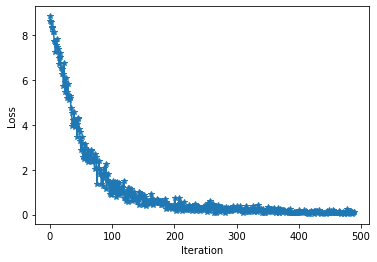

In [ ]:
new_l,new_bm = train_batch(newdataset_resnet,criterion,train_data,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,val_data,64,device_gpu)

0.9588917084854015

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data,64,device_gpu)

0.5200674019607843

In [ ]:
torch.save(new_bm,"newdataset_model_1.1")

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,64,device_gpu)

0.5231337480559876

#**EXTRAS**

MODEL ACCURACIES

In [ ]:
# def calc_accuracy2(net,test_data,batch_size=128,device='cpu'):
#     net = net.eval().to(device)
#     predictions = []
#     accuracy = 0
#     for i in range(len(test_data)):
#         #images,labels = test_data[i]
#         images = torch.unsqueeze(images,0)
#         #images,labels = test_data.get_batch(128)
#         outputs = infer(net,images)
#         correct = 0
#         for index,out in enumerate(outputs):
#             if out == labels:
#                 correct+=1

#         accuracy+=correct/len(outputs)

#     accuracy/=len(test_data)
#     return accuracy

METHOD-2

In [ ]:
# batch_size = 128
# traindata = []
# for i in range(len(X_train)):
#     elt = [X_train[i],Y_L_train[i]]
#     traindata.append(elt)

# valdata = []
# for i in range(len(X_val)):
#     elt = [X_val[i],Y_L_val[i]]
#     valdata.append(elt)

# trainloader = torch.utils.data.DataLoader(traindata,shuffle=True,batch_size=batch_size)
# valloader = torch.utils.data.DataLoader(valdata,shuffle=True,batch_size=batch_size)

In [ ]:
# dataiter = iter(trainloader)
# img,lab = next(dataiter)

In [ ]:
# def train_batch2(net,opt,criterion,dataloader,epochs=1000,display=True,device='cpu'):
    
#     loss_arr=[]
#     net.train().to(device)
#     for j in range(epochs):
#         for i,data in enumerate(dataloader):
        
            
#             opt.zero_grad()

#             inputs,labels = data
#             inputs,labels = inputs.to(device),labels.to(device)

#             outputs = net(inputs)
#             loss = criterion(outputs,labels.long())

#             loss.backward()
#             opt.step()

#             loss_arr.append(loss)
#             if display and (i%10==0):

#                 clear_output(wait=True)
#                 print('Iteration',i,'Loss',loss_arr[i])
#                 plt.figure()
#                 plt.plot(loss_arr[0:i],'-*')
#                 plt.xlabel('Iteration')
#                 plt.ylabel('Loss')
#                 plt.show()
#                 print('\n\n')
    
#     return loss_arr